# 8- K En Yakın Komşu (K-Nearest Neighbors) - Alıştırmalar

* Bu bölümdeki uygulamada, doğrusal olmayan K-En Yakın Komşu Regresyon modeli kullanılmıştır.

## Alıştırma - 1

### Verisetinin İncelenmesi ve Manipüle Edilmesi

In [1]:
# Gerekli kütüphanelerin dahil edilmesi,
import pandas as pd
import numpy as np
import seaborn as sns
import mglearn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

* Verisetini [buradan](https://mrkizmaz-s3data.s3.eu-west-1.amazonaws.com/DataSets/FuelConsumption.csv) indirebilirsiniz.

In [2]:
url = "https://mrkizmaz-s3data.s3.eu-west-1.amazonaws.com/DataSets/FuelConsumption.csv"

fuelcons = pd.read_csv(url)
df = fuelcons.copy()
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [3]:
df.isnull().values.any() # verisetinde bos degerler var mı?

False

In [4]:
df.info() # verisetinin bilgi cıktısını verir

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MODELYEAR                 1067 non-null   int64  
 1   MAKE                      1067 non-null   object 
 2   MODEL                     1067 non-null   object 
 3   VEHICLECLASS              1067 non-null   object 
 4   ENGINESIZE                1067 non-null   float64
 5   CYLINDERS                 1067 non-null   int64  
 6   TRANSMISSION              1067 non-null   object 
 7   FUELTYPE                  1067 non-null   object 
 8   FUELCONSUMPTION_CITY      1067 non-null   float64
 9   FUELCONSUMPTION_HWY       1067 non-null   float64
 10  FUELCONSUMPTION_COMB      1067 non-null   float64
 11  FUELCONSUMPTION_COMB_MPG  1067 non-null   int64  
 12  CO2EMISSIONS              1067 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 108.5+ KB


In [5]:
# modelyear veriseti bilgisinde int olarak görünüyor, aslında datetime olması gerekir.
df["MODELYEAR"] = pd.to_datetime(df["MODELYEAR"]) 

In [6]:
df.describe() # degiskenlerin istatistiksel degerleri

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


In [7]:
df.corr() # verisetinin degiskenleri arasındaki korelasyon durumu

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
ENGINESIZE,1.000000,0.934011,0.832225,0.778746,0.819482,-0.808554,0.874154
CYLINDERS,0.934011,1.000000,0.796473,0.724594,0.776788,-0.770430,0.849685
FUELCONSUMPTION_CITY,0.832225,0.796473,1.000000,0.965718,0.995542,-0.935613,0.898039
FUELCONSUMPTION_HWY,0.778746,0.724594,0.965718,1.000000,0.985804,-0.893809,0.861748
FUELCONSUMPTION_COMB,0.819482,0.776788,0.995542,0.985804,1.000000,-0.927965,0.892129
FUELCONSUMPTION_COMB_MPG,-0.808554,-0.770430,-0.935613,-0.893809,-0.927965,1.000000,-0.906394
CO2EMISSIONS,0.874154,0.849685,0.898039,0.861748,0.892129,-0.906394,1.000000


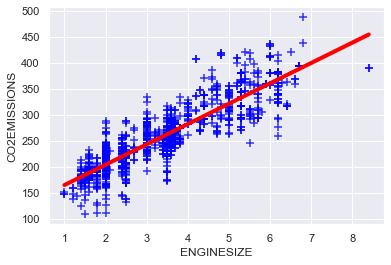

In [8]:
# enginesize ve co2emission görsel durumu
sns.set_theme(color_codes = True)
sns.regplot(data = df, x = 'ENGINESIZE', y = 'CO2EMISSIONS', 
            ci = 68, 
            marker = '+', 
            scatter_kws = {'s': 50, 'color' : 'blue'},
            line_kws = {'lw':4, 'color': 'red'});

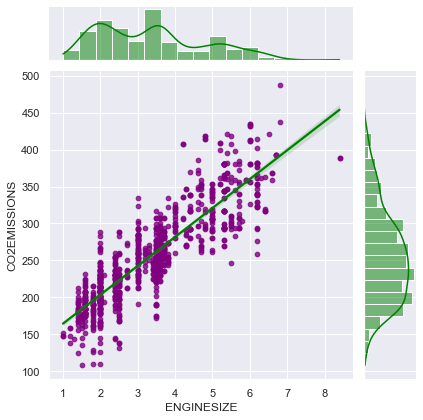

In [9]:
sns.jointplot(data = df, x = 'ENGINESIZE', y = 'CO2EMISSIONS', kind = 'reg', color = 'green', scatter_kws = {'color': 'purple', 's':22});

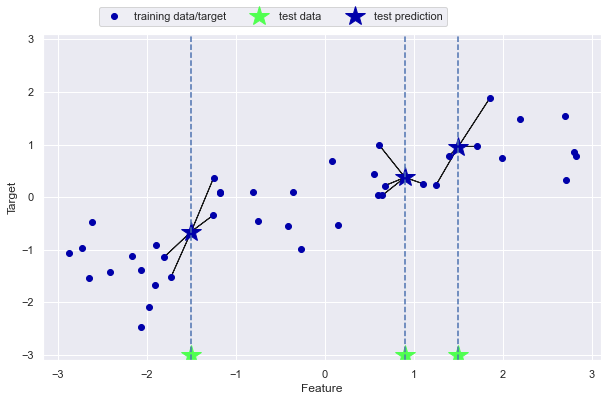

In [10]:
# örnegin, komsu sayısı 5 olan knn gösterimi,
mglearn.plots.plot_knn_regression(n_neighbors = 4)

### Model Kurulumu

In [11]:
df1 = df[['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB', 'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS']] # sürekli degiskenler
df1.head()

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2.0,4,9.9,6.7,8.5,33,196
1,2.4,4,11.2,7.7,9.6,29,221
2,1.5,4,6.0,5.8,5.9,48,136
3,3.5,6,12.7,9.1,11.1,25,255
4,3.5,6,12.1,8.7,10.6,27,244


In [12]:
X = df1.drop('CO2EMISSIONS', axis = 1) # bagımsız degiskenler (co2emissions haricindekiler)
y = df1['CO2EMISSIONS'] # bagımsız degisken

# %20 egitim seti, %80 test seti
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.20,
                                                   random_state = 42)
# optimum k degerinin belirlenmesi,
knn_params = {'n_neighbors': np.arange(1, 50, 1)}
knn = KNeighborsRegressor()
knncv = GridSearchCV(knn, knn_params, cv = 10).fit(X_train, y_train)

# modelin olusturulması ve hata degerinin bulunması,
knn_model = KNeighborsRegressor(knncv.best_params_['n_neighbors']).fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [13]:
rmse

12.02713054551577

In [14]:
rscore = knn_model.score(X_train, y_train)

In [15]:
rscore

0.9876900752018519

In [16]:
knncv.best_params_ # optimum k degeri

{'n_neighbors': 2}

In [17]:
print(f"Modelin basarı yüzdesi: {rscore * 100} \nModelin optimum hata degeri: {rmse}")

Modelin basarı yüzdesi: 98.7690075201852 
Modelin optimum hata degeri: 12.02713054551577


### SONUÇ

* K-En Yakın Komşu Regresyon modeli ile elde edilen degerler,
    * Modelin basarı yüzdesi: 98.7690075201852 
    * Modelin optimum hata degeri: **12.02713054551577**